# Distributed Training - Qwen2.5-7B-Instruct with FSDP2

This Kaggle notebook demonstrates fine-tuning the Qwen2.5-7B-Instruct model using Fully Sharded Data Parallelism version 2 (FSDP2) with QLoRA (4-bit quantization via BitsAndBytes) for parameter-efficient training. The setup runs on Kaggle's free dual T4 GPUs, leveraging mixed precision, CPU offloading, activation checkpointing, and LoRA adapters to minimize VRAM usage during distributed training.

The training logic is in a Python script (required for Accelerate’s multi-process launch) with inline comments for clarity. Post-training, we plot the training loss to visualize progress.

This aligns with the repo’s focus on efficient, GPU-friendly fine-tuning.

### Setup

In [1]:
!pip install --quiet trl accelerate==1.10.1 peft bitsandbytes git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 7.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 28.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.0/502.0 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 69.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
 

### Accelerate FSDP2 Configuration
The YAML config enables FSDP2 with:





- Sharding (version 2) and auto-wrapping for transformer layers.

- Optimizations: Reshard after forward, activation checkpointing, CPU offload, FP16 mixed precision.



- Full state dict for saving.

These reduce per-GPU memory usage for the 7B model.

In [2]:
%%writefile /kaggle/working/fsdp2_config.yaml

compute_environment: LOCAL_MACHINE
distributed_type: FSDP
downcast_bf16: no
fsdp_config:
  fsdp_version: 2
  reshard_after_forward: true
  transformer_cls_names_to_wrap: Qwen2DecoderLayer
  auto_wrap_policy: TRANSFORMER_BASED_WRAP  
  state_dict_type: FULL_STATE_DICT
  activation_checkpointing: true
  cpu_offload: true
  limit_all_gathers: true
  mixed_precision_policy:
    param_dtype: float16
    reduce_dtype: float32
    output_dtype: float16
    cast_forward_inputs: true
machine_rank: 0
main_training_function: main
mixed_precision: fp16
num_machines: 1
num_processes: 2
rdzv_backend: static
same_network: true
tpu_env: []
tpu_use_cluster: false
tpu_use_sudo: false
use_cpu: false

Writing /kaggle/working/fsdp2_config.yaml


### Training Script

In [3]:
%%writefile fsdp2_train.py

import os, gc, torch, json
from torch.distributed import destroy_process_group
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainerCallback
from peft import get_peft_model, LoraConfig, TaskType
from peft.utils.other import fsdp_auto_wrap_policy
from trl import SFTTrainer, SFTConfig
from datasets import load_dataset
from huggingface_hub import login

# Define training hyperparameters as a dict for easy modification
TRAIN_CONFIG = {
    "seed": 123,  # For reproducibility
    "max_steps": 100,  # Limited number of steps for demo
    "warmup_steps": 5,  # Quick warmup to stabilize LR
    "batch_size": 1,   # Per-device batch size
    "grad_accum_steps": 8,  # Accumulate gradients for effective larger batch
    "max_seq_length": 1024,  # Balance context vs. memor
    "learning_rate": 5e-5,  # Conservative LR for stable training
    "logging_steps": 5,  # Frequent logging for monitoring
    "output_dir": "/kaggle/working/output",
}

# Environment variables for optimization
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"  # Faster HF downloads
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # Use both GPUs
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,roundup_power2_divisions:[32:256,64:128,256:64,>:32]"  # Optimize CUDA memory allocation

# Custom callback to log GPU memory usage and save training logs
class GPUUsageCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_local_process_zero:  # Only save on rank 0 to avoid duplicates
            mem_alloc = torch.cuda.memory_allocated() / 1e9
            mem_reserved = torch.cuda.memory_reserved() / 1e9
            mem_peak = torch.cuda.max_memory_allocated() / 1e9
            print(f"[Mem Alloc = {mem_alloc:.2f}GB, Mem Reserved = {mem_reserved:.2f}GB, Mem Peak = {mem_peak:.2f}GB]")
            
            # Save step and loss to JSON
            logs_to_save = {"step": state.global_step, "loss": logs.get("loss", None), "mem_alloc": mem_alloc, "mem_reserved": mem_reserved}
            with open(os.path.join(args.output_dir, "train_logs.json"), "a") as f:
                f.write(json.dumps(logs_to_save) + "\n")
                
        return control

# Function to load dataset, model, and tokenizer
def load_train_objs():
    local_rank = int(os.environ.get("LOCAL_RANK", -1))
    if local_rank != -1:
        torch.cuda.set_device(local_rank)  # Set device per process

    model_name = "Qwen/Qwen2.5-7B-Instruct"

    # Load tokenizer and set pad token
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token

    # 4-bit quantization config for QLoRA
    bnb_cfg = BitsAndBytesConfig(
        load_in_4bit              = True,
        bnb_4bit_use_double_quant = True,  # Nested quantization for extra savings
        bnb_4bit_quant_type       = "nf4",  # Normalized float4 for better precision
        bnb_4bit_compute_dtype    = torch.float16,  # FP16 for computations
        bnb_4bit_quant_storage    = torch.float16,  # Store quantized weights in FP16
    )

    # Load model with quantization and device mapping
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        dtype               = torch.float16,  # Overall dtype
        device_map          = {"": local_rank} if local_rank != -1 else "auto",  # Map to process device
        attn_implementation = "sdpa",  # Scaled dot-product attention for efficiency
        low_cpu_mem_usage   = True,  # Reduce CPU memory during loading
        quantization_config = bnb_cfg,
    )

    # Load dataset (10% for demo)
    url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
    dataset = load_dataset("json", data_files={"train": url}, split="train[:10%]")

    return dataset, model, tokenizer

# Function to apply LoRA adapters
def apply_lora(model):
    # LoRA config: Target key modules, low dropout, causal LM task
    lora_cfg = LoraConfig(
        r              = 16,  # Rank of adapters
        lora_alpha     = 32,  # Scaling factor
        target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
        lora_dropout   = 0.0,
        bias           = "none",
        task_type      = TaskType.CAUSAL_LM,
    )

    # Get LoRA and setup model
    model = get_peft_model(model, lora_cfg)

    # Freeze base model, only train LoRA params
    with torch.no_grad():
        for name, param in model.named_parameters():
            if ".lora_A." in name or ".lora_B." in name:
                param.requires_grad_(True)
            else:
                param.requires_grad_(False)

    model.enable_input_require_grads()  # For gradient checkpointing if enabled
    model.config.use_cache = False  # Disable cache during training

    return model

# Main training function
def main():
    # Load objects
    dataset, model, tokenizer = load_train_objs()
    model = apply_lora(model)

    # Clear cache before training
    torch.cuda.empty_cache()
    gc.collect()
    
    # SFTTrainer args with FSDP integration
    training_args = SFTConfig(
        seed                        = TRAIN_CONFIG["seed"],
        max_steps                   = TRAIN_CONFIG["max_steps"],
        warmup_steps                = TRAIN_CONFIG["warmup_steps"],
        per_device_train_batch_size = TRAIN_CONFIG["batch_size"],
        gradient_accumulation_steps = TRAIN_CONFIG["grad_accum_steps"],
        max_length                  = TRAIN_CONFIG["max_seq_length"],
        learning_rate               = TRAIN_CONFIG["learning_rate"],
        logging_steps               = TRAIN_CONFIG["logging_steps"],
        output_dir                  = TRAIN_CONFIG["output_dir"],
        fp16                        = model.get_input_embeddings().weight.dtype == torch.float16,
        bf16                        = model.get_input_embeddings().weight.dtype == torch.bfloat16,
        fsdp                        = "full_shard",  # Full sharding for FSDP
        gradient_checkpointing      = False,  # Disabled here; enabled in FSDP2 config
        report_to                   = "none",  # No external logging
    )

    # Initialize trainer
    trainer = SFTTrainer(
        model            = model,
        args             = training_args,
        train_dataset    = dataset,
        processing_class = tokenizer,
        callbacks        = [GPUUsageCallback()],  # Memory logging
    )

    # Print FSDP setup info
    rank = trainer.accelerator.process_index
    print(f"[Rank {rank}] Plugin FSDP version: {trainer.accelerator.state.fsdp_plugin.fsdp_version}")
    print(f"[Rank {rank}] is_fsdp2: {trainer.accelerator.is_fsdp2}")
    print(f"[Rank {rank}] Distributed type: {trainer.accelerator.state.distributed_type}")
    print(f"[Rank {rank}] Device: {trainer.accelerator.device}")

    # Pre-training memory check
    rank = int(os.environ.get("LOCAL_RANK", 0))
    mem_alloc = torch.cuda.memory_allocated() / 1e9
    mem_reserved = torch.cuda.memory_reserved() / 1e9
    print(f"[Rank {rank}] Pre-training Mem Alloc = {mem_alloc:.2f}GB, Mem Reserved = {mem_reserved:.2f}GB")

    # Print trainable params
    trainer.model.print_trainable_parameters()

    # Start training
    trainer.train()

    # Save model with full state dict
    if trainer.is_fsdp_enabled:
        trainer.accelerator.state.fsdp_plugin.set_state_dict_type("FULL_STATE_DICT")
    trainer.save_model()

    # Clean up distributed processes
    destroy_process_group()

if __name__ == "__main__":
    main()


Writing fsdp2_train.py


### Launch Training

Launch with Accelerate using 2 GPUs. Monitor memory usage and training progress

In [4]:
!accelerate launch --config_file fsdp2_config.yaml --num_processes 2 fsdp2_train.py

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

### Training Loss Visualization

Since no evaluation dataset is used, we plot the training loss from the saved logs. The GPUUsageCallback saves logs to train_logs.json, which we load and visualize.

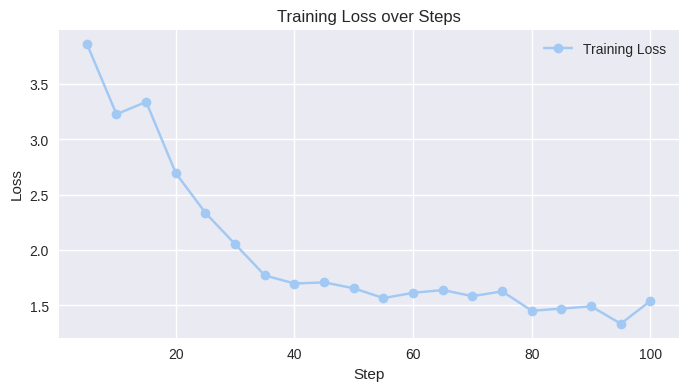

In [6]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load training logs
log_file = "/kaggle/working/output/train_logs.json"
train_entries = []
with open(log_file, "r") as f:
    for line in f:
        log = json.loads(line)
        if log.get("loss") is not None:
            train_entries.append((log["step"], log["loss"]))

# Extract steps and losses
train_steps, train_losses = zip(*train_entries) if train_entries else ([], [])

# Plot
plt.style.use('seaborn-v0_8')
sns.set_palette("pastel")
plt.figure(figsize=(8, 4))
plt.plot(train_steps, train_losses, marker='o', label='Training Loss')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid(True)
plt.show()